In [1]:
# Importing necessary modules

# Calculation and data handling
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ML Modules
import torch
import torchvision

# Data splitting
from sklearn.model_selection import train_test_split

gpu_check = torch.cuda.is_available()
if gpu_check:
    print("Training on GPU")
else:
    print("Training on CPU")

Training on GPU


In [2]:
# Import training dataset
df = pd.read_csv('train.csv')

In [3]:
# Define dictionary of output to description
Emotion = {0:'Anger',
           1:'Disgust',
           2:'Fear',
           3:'Happy',
           4:'Sad',
           5:'Surprise',
           6:'Neutral'}

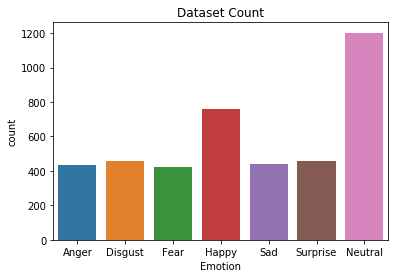

In [4]:
# Display dataset distribution
ax = sns.countplot(df['Emotion'])
ax.set(xticklabels = Emotion.values(), title = "Dataset Count")
plt.show()

In [5]:
# View first 5 rows of data
df.head()

,Emotion,Pixels
0,3,221 240 251 254 255 255 255 255 255 255 255 25...
1,6,100 107 108 104 103 113 117 115 120 130 138 14...
2,4,35 50 56 57 63 76 74 79 85 86 105 133 145 152 ...
3,6,119 124 129 135 136 140 142 149 159 156 163 16...
4,2,160 173 186 194 188 185 175 162 153 143 135 12...


The dataset shows that the images are stored in one cell and delimited with space.

In [6]:
# Define validation size set
val_size = 0.2

# Create a 3D array for our feature values
# Split the 'Pixels' column based on space
X = df['Pixels'].str.split(" ", expand = True)
# Convert dataset to float
X = np.asarray(X).astype(float)
# Normalize the dataset
X = X/255.0
# Reshape the dataset into a 4D array
X = X.reshape(-1,1,48,48)

# Create a 1D array for our target values
y = np.asarray(df['Emotion']).reshape(-1,1).astype(int)

# Stratify split the dataset to train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y)

# Show number of training and validation data
print(f'The number of items in X_train is {len(X_train)}.\nThe number of items in y_train is {len(y_train)}.\n')
print(f'The number of items in X_train is {len(X_val)}.\nThe number of items in y_train is {len(y_val)}.')

The number of items in X_train is 3342.
The number of items in y_train is 3342.

The number of items in X_train is 836.
The number of items in y_train is 836.


In [7]:
# Define function to display sample data
def display_tensor(x,y):
    plt.figure(figsize = (5,5))
    plt.imshow(x.reshape(48,48), cmap = 'gray')
    plt.title(y)
    plt.show()

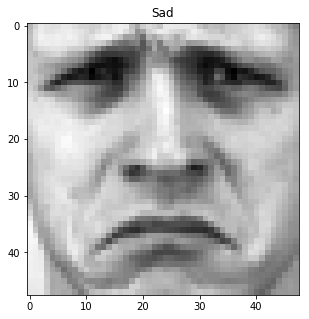

In [8]:
# Display a sample data
import random

ran = random.randint(0,len(X_train))
display_tensor(X[ran], Emotion[int(y[ran])])

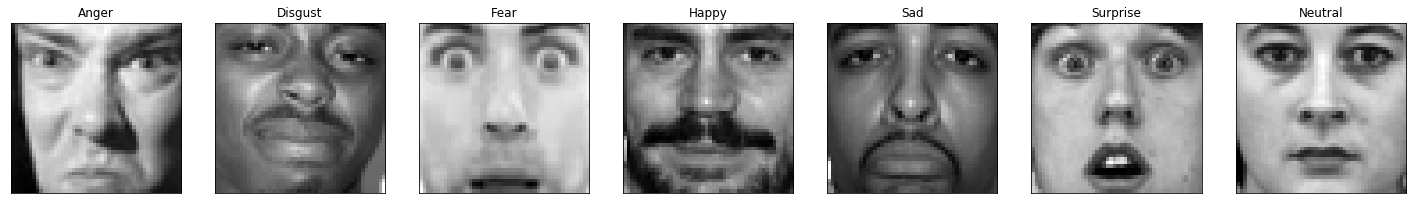

In [9]:
# Display sample faces per emotion
fig = plt.figure(figsize=(25, 4))
for i in range(len(Emotion)):
    ax = fig.add_subplot(1, 7, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train[np.argmax(y_train == i)].reshape(48,48)), cmap='gray')
    ax.set_title(Emotion[int(y_train[np.argmax(y_train == i)])])

In [10]:
# Create PyTorch dataset from the numpy dataset
import torch.utils.data as utils
import torchvision.transforms as transforms

# Create tensors of the training dataset for PyTorch
tensor_x = torch.stack([torch.Tensor(i) for i in X_train])
tensor_y = torch.stack([torch.Tensor(i) for i in y_train])
train_data = utils.TensorDataset(tensor_x, tensor_y)

# Create tensors of the validation dataset for PyTorch
tensor_x = torch.stack([torch.Tensor(i) for i in X_val])
tensor_y = torch.stack([torch.Tensor(i) for i in y_val])
valid_data = utils.TensorDataset(tensor_x, tensor_y)

In [11]:
# Define training and validation transforms
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomHorizontalFlip()])
valid_transform = transforms.Compose([transforms.ToTensor()])

In [12]:
# Define loader functions for training and validation set
num_workers = 0
batch_size = 20

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           shuffle = True, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size,
                                           shuffle = True, num_workers = num_workers)

In [13]:
# Define 3 layer convolutional reference
import torch.nn as nn
import torch.nn.functional as F

# Below are reference papers used
# https://arxiv.org/pdf/1302.4389v3.pdf  (student assistant solution)
# https://arxiv.org/ftp/arxiv/papers/1706/1706.01509.pdf (paper about emotion detection)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layer (sees 48x48x1 image tensor)
        self.conv1 = nn.Conv2d(1, 20, 5, padding = 3)
        # Convolutional layer (sees 24x24x10 image tensor)
        self.conv2 = nn.Conv2d(20, 20, 5, padding = 3)
        # Convolutional layer (sees 12x12x10 image tensor)
        self.conv3 = nn.Conv2d(20, 20, 3, padding = 1)
        
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(20*6*6, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)
        
        self.dropout = nn.Dropout(p = 0.25)
        
        self.logsoftmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv3(x)))
        x = x.view(-1, 6*6*20)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Set defined model as working model
model = Net()

In [14]:
# This line is added to upload the current best model parameters into the model based on previous training
# This line should not be used if the model was changed

# model.load_state_dict(torch.load('model.pth'))

In [15]:
# Define loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [16]:
# Define training epochs
n_epoch = 300

# Define starting validation loss and previous validation
valid_loss_ret = np.Inf
valid_loss_min = np.Inf

# If GPU is available, move model to GPU
if gpu_check:
    model.to('cuda')

# Main training loop
for epoch in range(n_epoch):
    
    # Initialize training and validation loss to zero
    train_loss = 0
    valid_loss = 0
    
    # Set model to train mode
    model.train()

    # Update model's learning rate on specific epochs
    if epoch == 100:
        optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
    if epoch == 200:
        optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001)
    
    # Define main training loop
    for data, target in train_loader:
        # Move data and target datasets to GPU if it is available
        if gpu_check:
            data, target = data.to('cuda'), target.to('cuda')
        # Remove empty dimensions
        target = target.squeeze()
        # Zero out gradients of the optimizer
        optimizer.zero_grad()
        # Generate model predictions
        output = model(data)
        # Calculate loss of model
        loss = criterion(output, target.long())
        # Perform back propagation
        loss.backward()
        # Update weights
        optimizer.step()
        # Calculate total training loss
        train_loss += loss.item() * data.size(0)
    
    # Set model to evaluation mode
    model.eval()
    
    # Define main validation loop
    for data, target in valid_loader:
        # Move data and target datasets to GPU if it is available
        if gpu_check:
            data, target = data.to('cuda'), target.to('cuda')
        # Remove empty dimensions
        target = target.squeeze()
        # Generate model predictions
        output = model(data)
        # Calculate loss of model
        loss = criterion(output, target.long())
        # Calculate total validation loss
        valid_loss += loss.item() * data.size(0)
    
    # Calculate average training loss of training and validation
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    # Save model state_dicts if validation loss improved
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model.pth')
        valid_loss_min = valid_loss
    
    # Print update if epoch is divisible by 25
    if epoch%25 == 0 and epoch>0:
        print(f'Trained from epoch {epoch - 25} to {epoch}')
        print('Validation accuracy improved from {:.6f} to {:.6f}'.format(valid_loss_ret,
                                                                          valid_loss_min))
        valid_loss_ret = valid_loss_min

Trained from epoch 0 to 25
Validation accuracy improved from inf to 1.679442
Trained from epoch 25 to 50
Validation accuracy improved from 1.679442 to 1.004465
Trained from epoch 50 to 75
Validation accuracy improved from 1.004465 to 0.701661
Trained from epoch 75 to 100
Validation accuracy improved from 0.701661 to 0.601982
Trained from epoch 100 to 125
Validation accuracy improved from 0.601982 to 0.592610
Trained from epoch 125 to 150
Validation accuracy improved from 0.592610 to 0.590353
Trained from epoch 150 to 175
Validation accuracy improved from 0.590353 to 0.590353
Trained from epoch 175 to 200
Validation accuracy improved from 0.590353 to 0.590353
Trained from epoch 200 to 225
Validation accuracy improved from 0.590353 to 0.590353
Trained from epoch 225 to 250
Validation accuracy improved from 0.590353 to 0.590353
Trained from epoch 250 to 275
Validation accuracy improved from 0.590353 to 0.590353


In [17]:
# This line is added to upload the current best model parameters into the model based on previous training
model.load_state_dict(torch.load('model.pth'))

In [18]:
# Define function to predict output and compare with ground truth
def test_model(img, label, model):
    X = torch.Tensor(img.reshape(1,1,48,48))
    output = model(X)
    _, pred = torch.max(output,1)
    Emotion[int(pred)], label, pred
    display_tensor(X, f'Prediction: {Emotion[int(pred)]}\nActual:{label}')

In [22]:
# Calculate percent accuracy of model in the validation set
from tqdm import tqdm

model.to('cpu')
y_pred = []
corr = 0
wrong = []
for i in tqdm(range(len(X_val))):
    output = model(torch.Tensor(X_val[i].reshape(1,1,48,48)))
    _, pred = torch.max(output,1)
    y_pred.append(pred)
    if int(pred) == int(y_val[i]):
        corr += 1
    else:
        wrong.append(i)

print("The model's accuracy is {:.2f}%".format(corr*100/len(X_val)))

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:01<00:00, 487.79it/s]


The model's accuracy is 80.14%


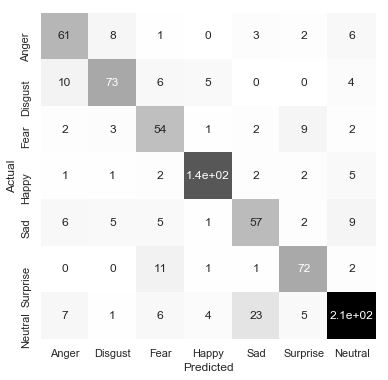

In [20]:
# Generate a confusion matrix to identify what the model incorrectly identifies
from sklearn.metrics import confusion_matrix

sns.set(rc={'figure.figsize':(6,6)})
ax = sns.heatmap(confusion_matrix(y_pred, y_val), cmap='gray_r', 
                 annot = True, cbar = False, 
                 xticklabels = list(Emotion.values()),
                 yticklabels = list(Emotion.values()))
ax.set(xlabel='Predicted', ylabel='Actual')
plt.show()

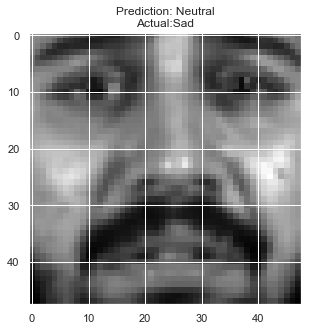

In [31]:
# Sample of incorrect prediction
ran = wrong[8]
test_model(X_val[ran], Emotion[int(y_val[ran])], model)